


















.# Attention based RUL prediction (for FD001)

In this notebook, we will use attention along with gated recurrent unit (GRU) to make RUL prediction. We will only show the implementation of attention without going too much into the theory and motivation of it. Readers interested to learn more about attention are directed to [Chapter 10](https://d2l.ai/chapter_attention-mechanisms/index.html) of [Dive into Deep Learning](https://d2l.ai/index.html) book. We will use the `Tensorflow` implementation of `Attention Mechanisms` chapter of that book that was in fact written by yours truly (some shameless self-promotion).

This notebook is going to be relatively long. So we have divided it into different sections. Readers can read sections selectively depending on their choice.

* A whirlwind tour of attention
* Data preparation
* Model creation
    * Encoder
    * Attention mechanism
    * Decoder (with attention)
* Model training
* Making predictions
* Evaluating RMSE and S-score
* How to reporduce our result?

## A whirlwind tour of attention:

![Attention based prediction](attention_mechanism.png)

Attention mechanism was developed to overcome some of the limitations of `encoder-decoder` architecture. Attention mechanism also uses encoder-decoder architecture but with a slight variation. In the vanilla encoder-decoder model, encoder transforms the inputs to a hidden representation. The hidden representation is then passed to decoder model for prediction. One of the limitations of vanilla encoder-decoder model is that for long sequences, the encoded representation is not sufficient to encode all the information of the input sequence. So decoder outcomes become suboptimal. To overcome this challenge, in attention layer, the encoded representation is combined with hidden states of intermediate units to come up with a new hidden representation. As the new hidden representation takes intermediate hidden states into account, it represents the input more effectively. The new hidden representation is then passed to the decoder for prediction. There are basically two steps to attention:

* Attention weight calculation, and
* Linear combination of intermediate states with attention weights

The way in which attention weights (scalars) are computed decides the name of the attention layer. There are infact many ways in which we can compute attention weights. But two of the most commons ones are `Additive attention` and `Dot-product attention` (also called multiplicative attention). Addtive attention computes attention weights in one way while dot-product attention computes it in a different way. After computation of attention weights, new hidden representation is computed and passed to the decoder layer. For more details readers are encouraged to read `Chapter 10` of `Dive into Deep Learning` book.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preparation

Before using our model, we will first process the data. For data preprocessing we will be using three functions as defined below. Without any prior description these functions may seem weird. But these functions are not that difficult to use. A detailed description of the dataset used and preprocessing steps (along with the functions defined below) is given in [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). Readers are strongly encouraged to go through that notebook first to get an intuitive understanding of how the preprocessing steps work.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Cmaps.zip' -d /content/dataset



Archive:  /content/drive/MyDrive/Cmaps.zip
  inflating: /content/dataset/CMaps/Damage Propagation Modeling.pdf  
  inflating: /content/dataset/CMaps/RUL_FD001.txt  
  inflating: /content/dataset/CMaps/RUL_FD002.txt  
  inflating: /content/dataset/CMaps/RUL_FD003.txt  
  inflating: /content/dataset/CMaps/RUL_FD004.txt  
  inflating: /content/dataset/CMaps/readme.txt  
  inflating: /content/dataset/CMaps/test_FD001.txt  
  inflating: /content/dataset/CMaps/test_FD002.txt  
  inflating: /content/dataset/CMaps/test_FD003.txt  
  inflating: /content/dataset/CMaps/test_FD004.txt  
  inflating: /content/dataset/CMaps/train_FD001.txt  
  inflating: /content/dataset/CMaps/train_FD002.txt  
  inflating: /content/dataset/CMaps/train_FD003.txt  
  inflating: /content/dataset/CMaps/train_FD004.txt  
  inflating: /content/dataset/CMaps/x.txt  


In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 1


In [ ]:


window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-5-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-5-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


<ipython-input-6-fef618501205>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
<ipython-input-5-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data)).batch(128).prefetch(tf.data.AUTOTUNE)

## Model creation

We will first create an encoder, then the attention mechanism (to compute attention weights), then the decoder, and finally combine the encoder and decoder into a single model.

###  Encoder

In [ ]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(*kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

### Additive attention
Along with computing attention weights, we will also compute the linear combination in this layer.

In [ ]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)

    def call(self, state, encoder_outputs):
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        # Hidden states of stacked GRU are first averaged before computing attention weights as done below
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1)
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

### Decoder

In [ ]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)

    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)


    def call(self, dec_input, state, **kwargs):
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

### Combine the encoder and decoder

In [ ]:
class EncoderDecoder(tf.keras.Model):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)

In [ ]:
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

### Combined model

In [ ]:
net = EncoderDecoder(encoder, decoder)

## Training

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    for epoch in range(num_epochs):
        for batch in data_iter:
            X, Y = [x for x in batch]
            dec_input = X[:, -1, tf.newaxis]  # Only the last step of each input
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, training = True)
                l = loss_object(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        print(f'epoch {epoch + 1}, loss {l}')

In [ ]:
train_seq2seq(net, train_dataset, 0.001, 10)

epoch 1, loss 0.012392260134220123
epoch 2, loss 0.008131453767418861
epoch 3, loss 0.007957737892866135
epoch 4, loss 0.008263053372502327
epoch 5, loss 0.008174411952495575
epoch 6, loss 0.008042573928833008
epoch 7, loss 0.007358882576227188
epoch 8, loss 0.006965751759707928
epoch 9, loss 0.006549105513840914
epoch 10, loss 0.0059949192218482494


In [ ]:
net.save_weights("FD001-ABGRU.h5")

## Prediction

In [ ]:
def predict_seq2seq(net, test_data_iter):
    final_preds = []
    for batch in test_data_iter:
        enc_outputs = net.encoder(batch, training = False)
        dec_state = net.decoder.init_state(enc_outputs)
        dec_X = batch[:, -1, tf.newaxis]
        Y_pred, _ = net.decoder(dec_X, dec_state, training = False)
        final_preds.append(Y_pred.numpy())
    return tf.squeeze(tf.concat(final_preds, axis = 0).numpy()).numpy()

In [ ]:
rul_pred_unscaled = predict_seq2seq(net, test_dataset)

In [ ]:
rul_pred = target_scaler.inverse_transform(rul_pred_unscaled.reshape(-1, 1)).reshape(-1)

In [ ]:
true_rul= np.clip(true_rul, a_min=0, a_max=125)
rul_pred = np.clip(rul_pred, a_min=0, a_max=125)

In [ ]:
true_rul.max()

125

In [ ]:
rul_pred.max()

125.0

S-score

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

### Computing RMSE and MAE using last 5 examples

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE  % " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  13.413820939750597
MAE:  9.803134884119034
MAE  %  0.15964897760566205
S-score:  351.0633354114789


### Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  13.235542072878895
MAE (Taking only last example):  10.029953830242157
MAE    0.17049323918300416
S-score:  294.14012061618837


### Computing S-score

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  558.510885002161


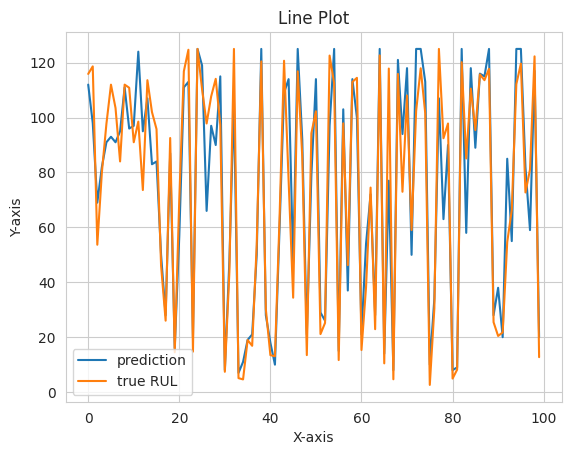

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

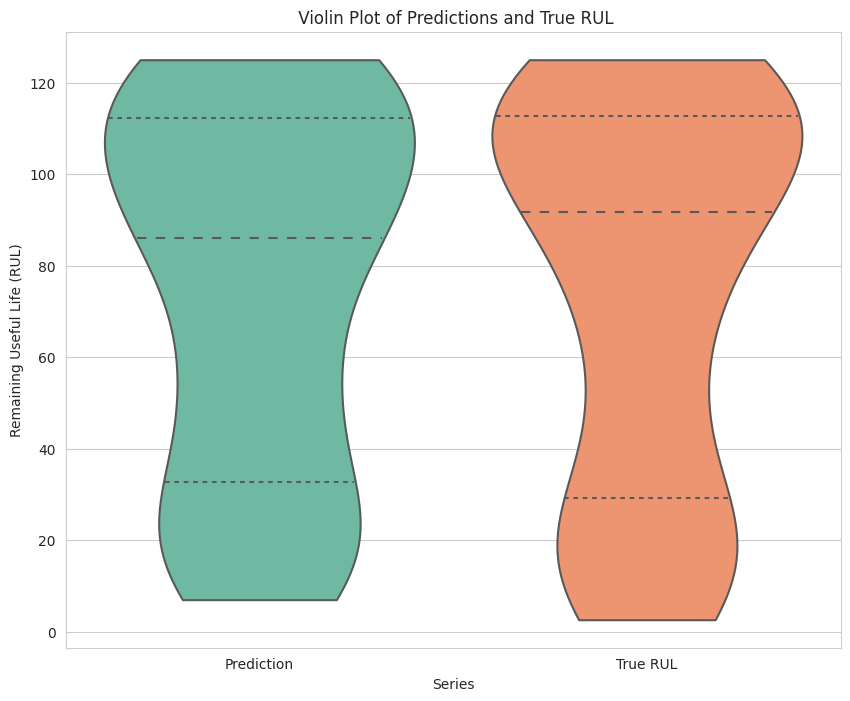

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


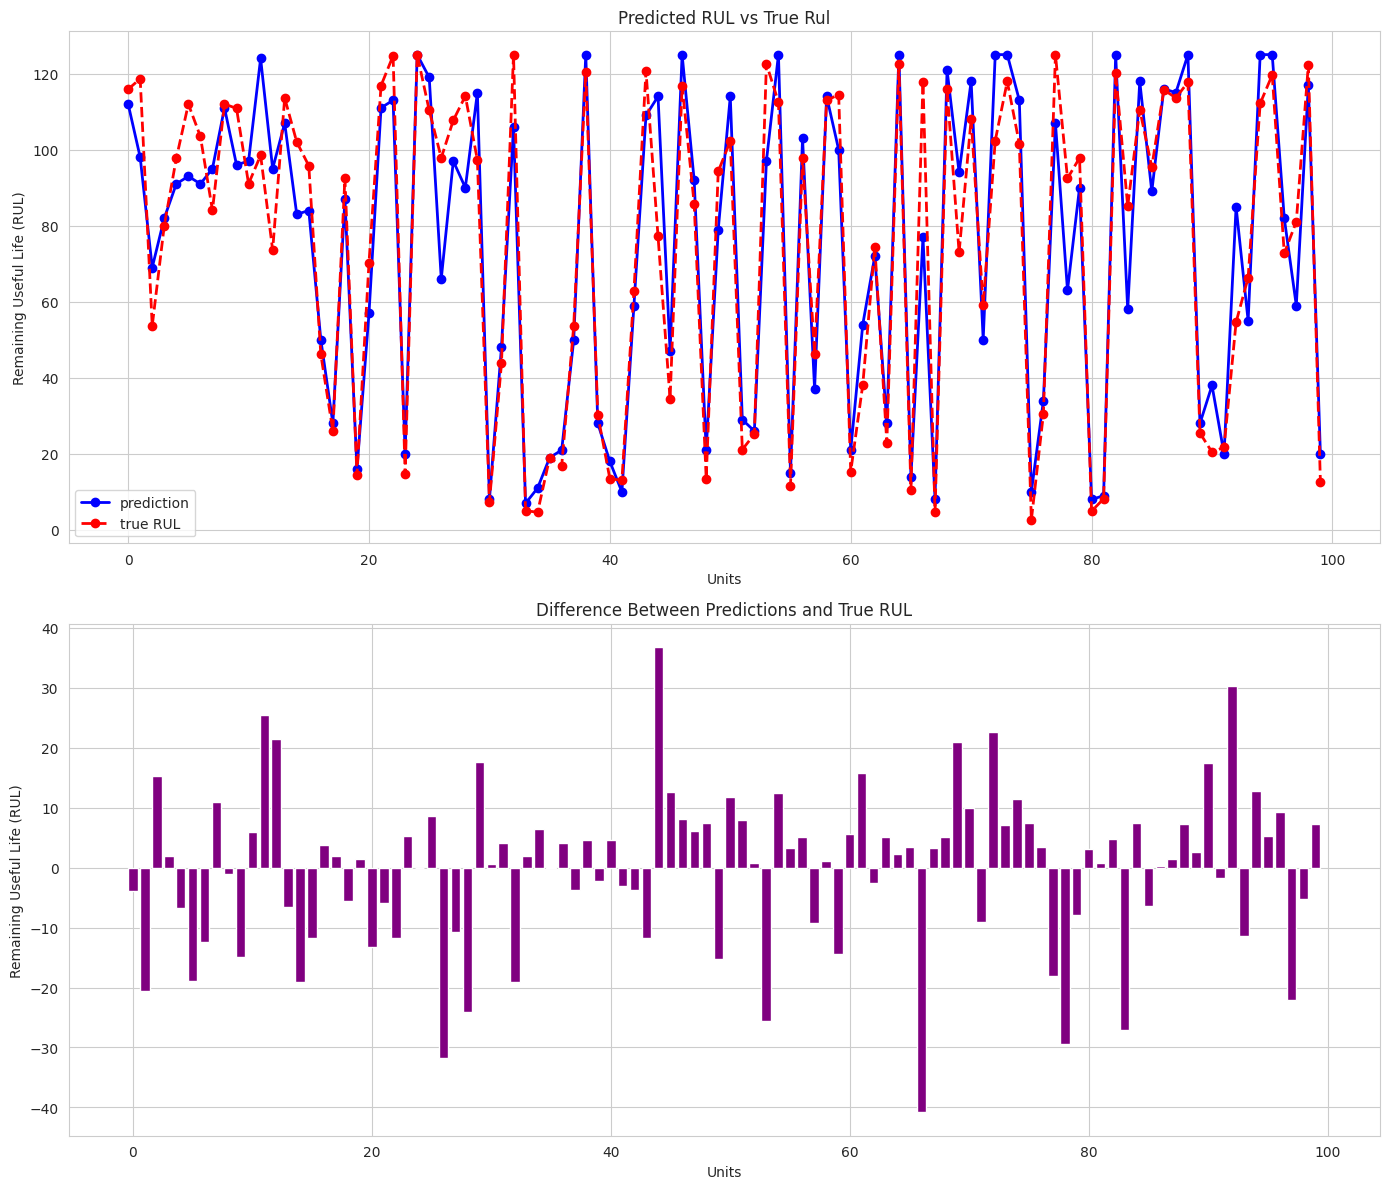

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 3.3405057854122586


In [ ]:
net.save_weights("./saved_weights/FD001/FD001_early_rul_125_GRU_rmse_14_21")

## How to reproduce our results?

It is very likely that after running this notebook, readers may get slightly different (occasionally very differnt) results than what we have obtained here. This happens because many deep learning operations are inherently non-deterministic in nature. However, exact reproducibility can be achieved if weights of the trained model are shared. To allow readers to reproduce our results, we have shared the trained model weights [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/attention_based_RUL/saved_weights). Steps to use shared model weights is given in [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/attention_based_RUL/Reproduce_results_of_FD001_early_rul_125_GRU.ipynb). By running [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/attention_based_RUL/Reproduce_results_of_FD001_early_rul_125_GRU.ipynb), results will get the exact same results that we have obtained.

Interested readers who wish to know about other methods of RUL prediction can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open/).

# Attention based RUL prediction (for FD002)

In this notebook, we will use attention along with gated recurrent unit (GRU) to make RUL prediction. We will only show the implementation of attention without going too much into the theory and motivation of it. Readers interested to learn more about attention are directed to [Chapter 10](https://d2l.ai/chapter_attention-mechanisms/index.html) of [Dive into Deep Learning](https://d2l.ai/index.html) book. We will use the `Tensorflow` implementation of `Attention Mechanisms` chapter of that book that was in fact written by yours truly (some shameless self-promotion).

This notebook is going to be relatively long. So we have divided it into different sections. Readers can read sections selectively depending on their choice.

* A whirlwind tour of attention
* Data preparation
* Model creation
    * Encoder
    * Attention mechanism
    * Decoder (with attention)
* Model training
* Making predictions
* Evaluating RMSE and S-score
* How to reporduce our result?

## A whirlwind tour of attention:

![Attention based prediction](attention_mechanism.png)

Attention mechanism was developed to overcome some of the limitations of `encoder-decoder` architecture. Attention mechanism also uses encoder-decoder architecture but with a slight variation. In the vanilla encoder-decoder model, encoder transforms the inputs to a hidden representation. The hidden representation is then passed to decoder model for prediction. One of the limitations of vanilla encoder-decoder model is that for long sequences, the encoded representation is not sufficient to encode all the information of the input sequence. So decoder outcomes become suboptimal. To overcome this challenge, in attention layer, the encoded representation is combined with hidden states of intermediate units to come up with a new hidden representation. As the new hidden representation takes intermediate hidden states into account, it represents the input more effectively. The new hidden representation is then passed to the decoder for prediction. There are basically two steps to attention:

* Attention weight calculation, and
* Linear combination of intermediate states with attention weights

The way in which attention weights (scalars) are computed decides the name of the attention layer. There are infact many ways in which we can compute attention weights. But two of the most commons ones are `Additive attention` and `Dot-product attention` (also called multiplicative attention). Addtive attention computes attention weights in one way while dot-product attention computes it in a different way. After computation of attention weights, new hidden representation is computed and passed to the decoder layer. For more details readers are encouraged to read `Chapter 10` of `Dive into Deep Learning` book.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 2


In [ ]:
true_rul.min()

0    6
dtype: int64

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preparation

Before using our model, we will first process the data. For data preprocessing we will be using three functions as defined below. Without any prior description these functions may seem weird. But these functions are not that difficult to use. A detailed description of the dataset used and preprocessing steps (along with the functions defined below) is given in [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). Readers are strongly encouraged to go through that notebook first to get an intuitive understanding of how the preprocessing steps work.

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    dec_input_data = np.repeat(np.nan, repeats = num_batches * num_features).reshape(num_batches, 1, num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            dec_input_data[batch, :, :] = output_data[batch, :, :][-1]
        return output_data, dec_input_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

We will modify the next functions a little bit to handle a special case. Later, for this dataset, we will be using window_size of 30. But upon some investigation, it can be found that there are a few test engines for which test data doesn't contain 30 rows. If test data for an engine doesn't contain 30 rows, how can we extract 30 rows from it? To circumvent this issue, we will append zeros to the end of that dataset. But while making predictions, we will ignore those appended zeros. This is called masking. The appended extra zeros are masked so that it doesn't influence our prediction. In `Tensorflow`, RNN layers can take a mask argument to ignore specific input values. So we modify the function below to create a mask that is compatible with `Tensorflow`.

Similarly, to the decoder we pass only the last line of every window of test dataset. But if we have appended last few lines of data of an engine by zeros, taking its last row would mean taking all zeros. To overcome this problem, the function returns `test_decoder_for_an_engine` as another output.

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        test_decoder_for_an_engine = test_data_for_an_engine[-1][np.newaxis, np.newaxis, :]
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :], test_decoder_for_an_engine

    else:
        max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1

        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine, test_decoder_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask, test_decoder_for_an_engine

        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine, test_decoder_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask,  test_decoder_for_an_engine

In [ ]:


window_length = 30
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

# train_mask = []
test_mask = []
test_decoder_input = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine, test_decoder_input_for_an_engine = process_test_data(temp_test_data,
                                                                                                                        window_length = window_length,
                                                                                                                        shift = shift,
                                                                                                                        num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)
    test_decoder_input.append(test_decoder_input_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)
test_decoder_input = np.concatenate(test_decoder_input)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("Test decode input shape: ", test_decoder_input.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-90-196032e79c20>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-90-196032e79c20>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

Processed trianing data shape:  (46219, 30, 21)
Processed training ruls shape:  (46219,)
Processed test data shape:  (1267, 30, 21)
Test mask shape:  (1267, 30)
Test decode input shape:  (1267, 1, 21)
True RUL shape:  (259,)


Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask, test_decoder_input)).batch(128).prefetch(tf.data.AUTOTUNE)

## Model creation

We will first create an encoder, then the attention mechanism (to compute attention weights), then the decoder, and finally combine the encoder and decoder into a single model.

### Encoder

In [ ]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, *args, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

### Additive attention
Along with computing attention weights, we will also compute the linear combination in this layer.

In [ ]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)

    def call(self, state, encoder_outputs):
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1)
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

### Decoder

In [ ]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)

    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)


    def call(self, dec_input, state, **kwargs):
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, initial_state = enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

### Combine encoder and decoder

In [ ]:
class EncoderDecoder(tf.keras.Model):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)

In [ ]:
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

In [ ]:
net = EncoderDecoder(encoder, decoder)

## Training

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    for epoch in range(num_epochs):
        for X, Y in data_iter:
            dec_input = X[:, -1, tf.newaxis]  # Only the last step of each input
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, training = True)
                l = loss_object(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        print(f'epoch {epoch + 1}, {l}')

In [ ]:
train_seq2seq(net, train_dataset, 0.001, 10)

epoch 1, 0.04562996327877045
epoch 2, 0.05038532242178917
epoch 3, 0.049197424203157425
epoch 4, 0.04113512486219406
epoch 5, 0.03686024248600006
epoch 6, 0.032171886414289474
epoch 7, 0.030116938054561615
epoch 8, 0.02947762794792652
epoch 9, 0.030062196776270866
epoch 10, 0.030589593574404716


## Prediction

In [ ]:
def predict_seq2seq(net, test_data_iter):
    final_preds = []
    for test_data_batch, test_mask_batch, test_dec_input in test_data_iter:
        enc_outputs = net.encoder(test_data_batch, mask = test_mask_batch, training = False)
        dec_state = net.decoder.init_state(enc_outputs)
        Y_pred, _ = net.decoder(test_dec_input, dec_state, training = False)
        final_preds.append(Y_pred.numpy())
    return tf.squeeze(tf.concat(final_preds, axis = 0).numpy()).numpy()

In [ ]:
rul_pred_unscaled = predict_seq2seq(net, test_dataset)

In [ ]:
rul_pred = target_scaler.inverse_transform(rul_pred_unscaled.reshape(-1, 1)).reshape(-1)

In [ ]:
true_rul= np.clip(true_rul, a_min=0, a_max=150)
rul_pred = np.clip(rul_pred, a_min=0, a_max=150)

### Computing RMSE and MAE using last 5 examples

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  20.513936150798237
MAE:  15.293636539543918
MAE    0.26414984361490496
S-score:  2969.378551753547


### Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  20.26927261783953
MAE (Taking only last example):  15.175361980802764
MAE    0.2532281144651189
S-score:  2414.26951001166


In [ ]:
net.save_weights("FD002_ABGRU")

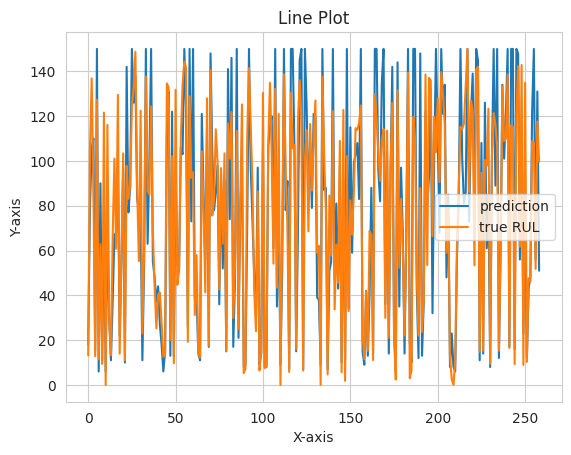

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

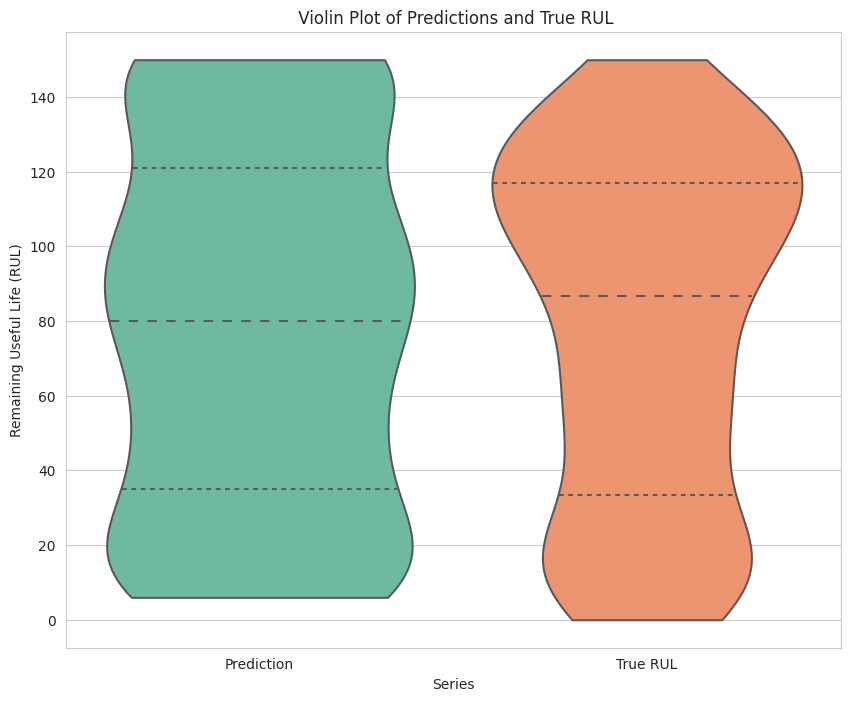

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


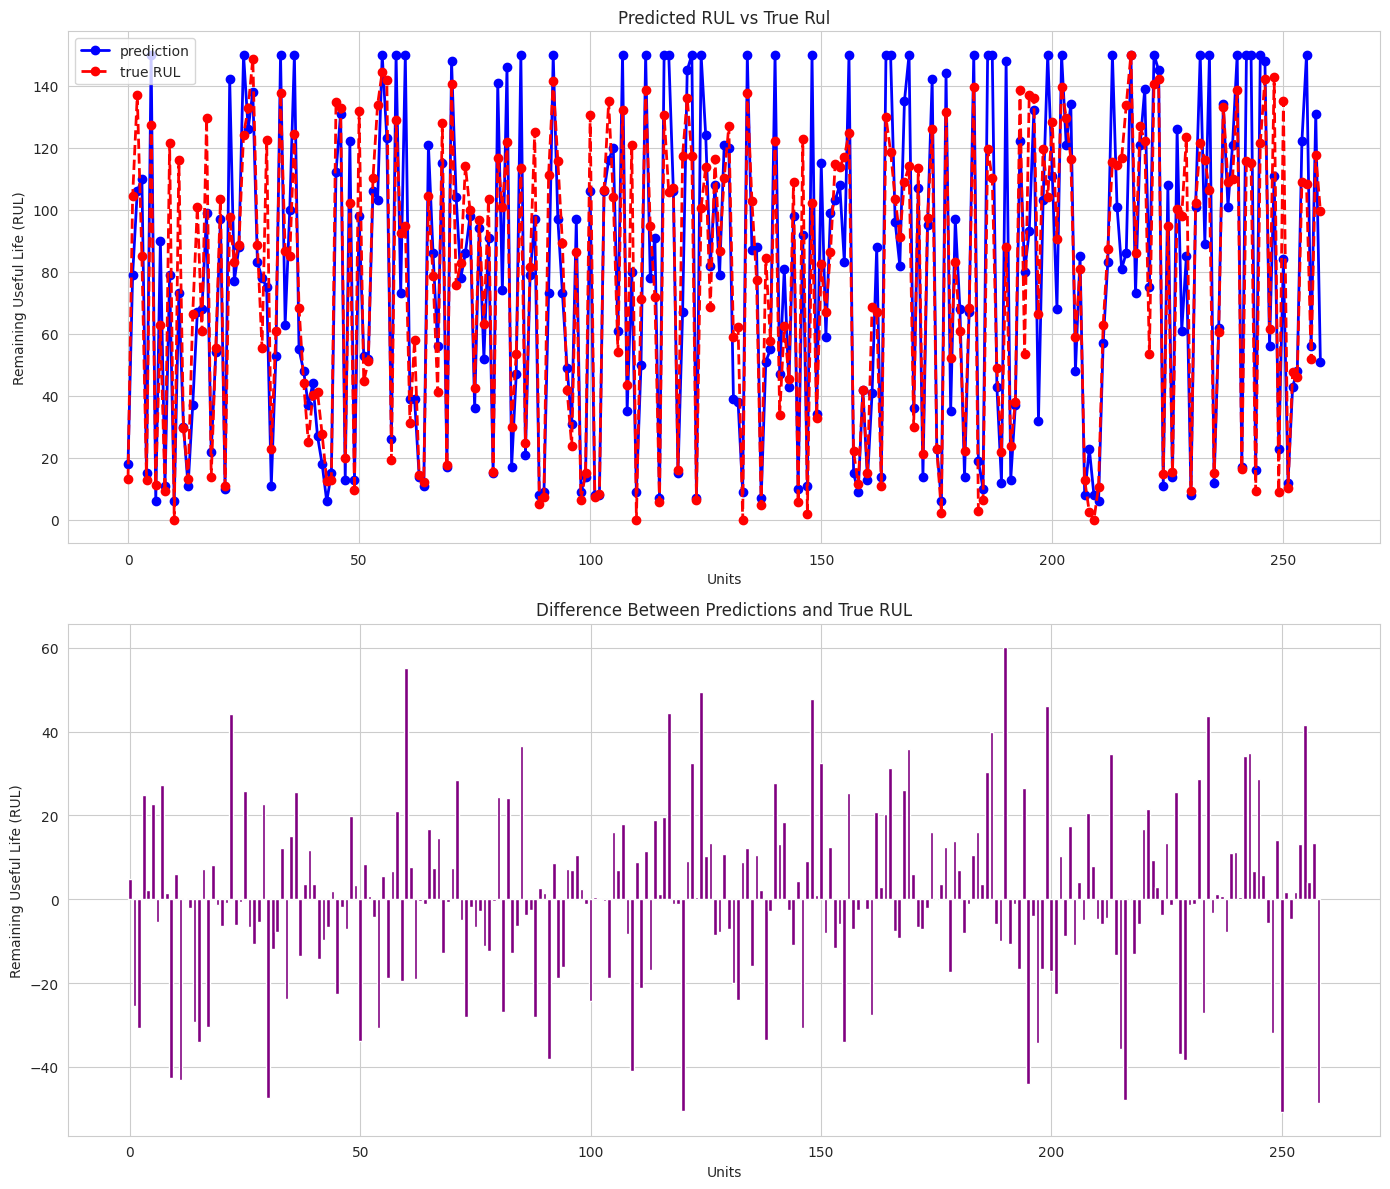

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 4.170437205128554


# Attention based RUL prediction (for FD003)

In this notebook, we will use attention along with gated recurrent unit (GRU) to make RUL prediction. We will only show the implementation of attention without going too much into the theory and motivation of it. Readers interested to learn more about attention are directed to [Chapter 10](https://d2l.ai/chapter_attention-mechanisms/index.html) of [Dive into Deep Learning](https://d2l.ai/index.html) book. We will use the `Tensorflow` implementation of `Attention Mechanisms` chapter of that book that was in fact written by yours truly (some shameless self-promotion).

This notebook is going to be relatively long. So we have divided it into different sections. Readers can read sections selectively depending on their choice.

* A whirlwind tour of attention
* Data preparation
* Model creation
    * Encoder
    * Attention mechanism
    * Decoder (with attention)
* Model training
* Making predictions
* Evaluating RMSE and S-score
* How to reporduce our result?

## A whirlwind tour of attention:

![Attention based prediction](attention_mechanism.png)

Attention mechanism was developed to overcome some of the limitations of `encoder-decoder` architecture. Attention mechanism also uses encoder-decoder architecture but with a slight variation. In the vanilla encoder-decoder model, encoder transforms the inputs to a hidden representation. The hidden representation is then passed to decoder model for prediction. One of the limitations of vanilla encoder-decoder model is that for long sequences, the encoded representation is not sufficient to encode all the information of the input sequence. So decoder outcomes become suboptimal. To overcome this challenge, in attention layer, the encoded representation is combined with hidden states of intermediate units to come up with a new hidden representation. As the new hidden representation takes intermediate hidden states into account, it represents the input more effectively. The new hidden representation is then passed to the decoder for prediction. There are basically two steps to attention:

* Attention weight calculation, and
* Linear combination of intermediate states with attention weights

The way in which attention weights (scalars) are computed decides the name of the attention layer. There are infact many ways in which we can compute attention weights. But two of the most commons ones are `Additive attention` and `Dot-product attention` (also called multiplicative attention). Addtive attention computes attention weights in one way while dot-product attention computes it in a different way. After computation of attention weights, new hidden representation is computed and passed to the decoder layer. For more details readers are encouraged to read `Chapter 10` of `Dive into Deep Learning` book.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 3


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preparation

Before using our model, we will first process the data. For data preprocessing we will be using three functions as defined below. Without any prior description these functions may seem weird. But these functions are not that difficult to use. A detailed description of the dataset used and preprocessing steps (along with the functions defined below) is given in [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). Readers are strongly encouraged to go through that notebook first to get an intuitive understanding of how the preprocessing steps work.

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [ ]:

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-107-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-107-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

Processed trianing data shape:  (21820, 30, 15)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 15)
True RUL shape:  (100,)


<ipython-input-107-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-107-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data)).batch(128).prefetch(tf.data.AUTOTUNE)

## Model creation

We will first create an encoder, then the attention mechanism (to compute attention weights), then the decoder, and finally combine the encoder and decoder into a single model.

## Encoder

In [ ]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(*kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

### Additive attention
Along with computing attention weights, we will also compute the linear combination in this layer.

In [ ]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)

    def call(self, state, encoder_outputs):
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1)
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

### Decoder

In [ ]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)

    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)


    def call(self, dec_input, state, **kwargs):
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

### Combine encoder and decoder

In [ ]:
class EncoderDecoder(tf.keras.Model):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)

In [ ]:
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

## Combined model

In [ ]:
net = EncoderDecoder(encoder, decoder)

## Training

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    for epoch in range(num_epochs):
        for batch in data_iter:
            X, Y = [x for x in batch]
            dec_input = X[:, -1, tf.newaxis]  # Only the last step of each input
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, training = True)
                l = loss_object(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        print(f'epoch {epoch + 1}, {l}')

In [ ]:
train_seq2seq(net, train_dataset, 0.001, 15)

epoch 1, 0.013541239313781261
epoch 2, 0.009172272868454456
epoch 3, 0.0075838444754481316
epoch 4, 0.006978555116802454
epoch 5, 0.006895721890032291
epoch 6, 0.006884655449539423
epoch 7, 0.0067725153639912605
epoch 8, 0.0064676543697714806
epoch 9, 0.00593975093215704
epoch 10, 0.005257573444396257
epoch 11, 0.004568665754050016
epoch 12, 0.003993057180196047
epoch 13, 0.0035413706209510565
epoch 14, 0.0031541346106678247
epoch 15, 0.002771597122773528


## Prediction

In [ ]:
def predict_seq2seq(net, test_data_iter):
    final_preds = []
    for batch in test_data_iter:
        enc_outputs = net.encoder(batch, training = False)
        dec_state = net.decoder.init_state(enc_outputs)
        dec_X = batch[:, -1, tf.newaxis]
        Y_pred, _ = net.decoder(dec_X, dec_state, training = False)
        final_preds.append(Y_pred.numpy())
    return tf.squeeze(tf.concat(final_preds, axis = 0).numpy()).numpy()

In [ ]:
rul_pred_unscaled = predict_seq2seq(net, test_dataset)

In [ ]:
rul_pred = target_scaler.inverse_transform(rul_pred_unscaled.reshape(-1, 1)).reshape(-1)

In [ ]:
true_rul= np.clip(true_rul, a_min=0, a_max=125)
rul_pred = np.clip(rul_pred, a_min=0, a_max=125)

### Computing RMSE and MAE using last 5 examples

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  14.103426934833383
MAE:  10.868022865056993
MAE    0.23870685939251998
S-score:  374.0817596009442


### Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  13.17705027772596
MAE (Taking only last example):  9.788468647003175
MAE    0.19544905877786822
S-score:  315.2600460373167


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 5.993774202134874


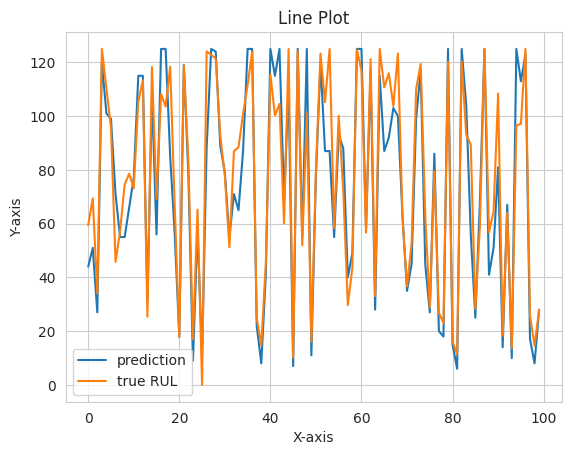

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

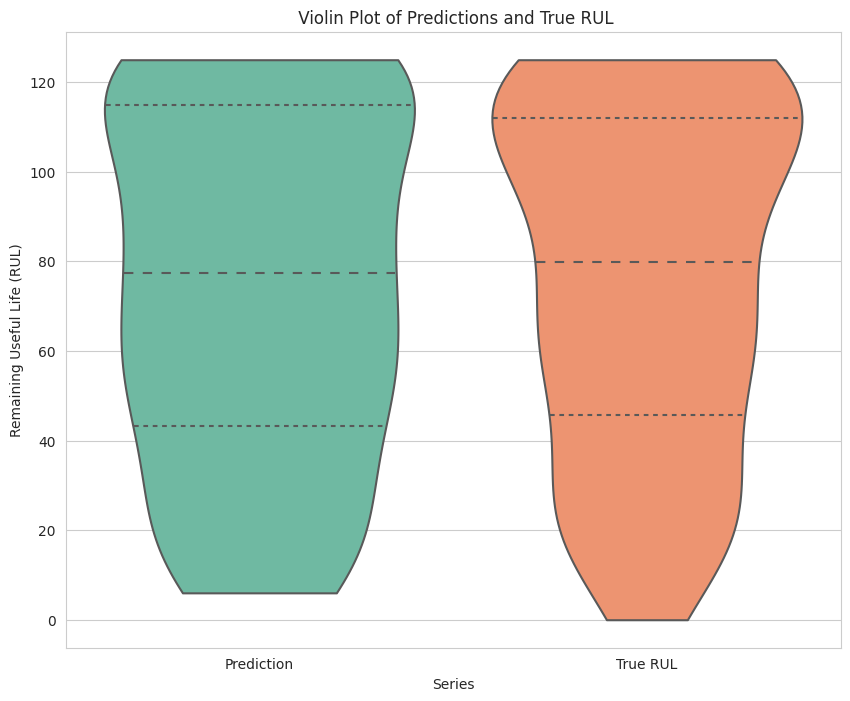

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


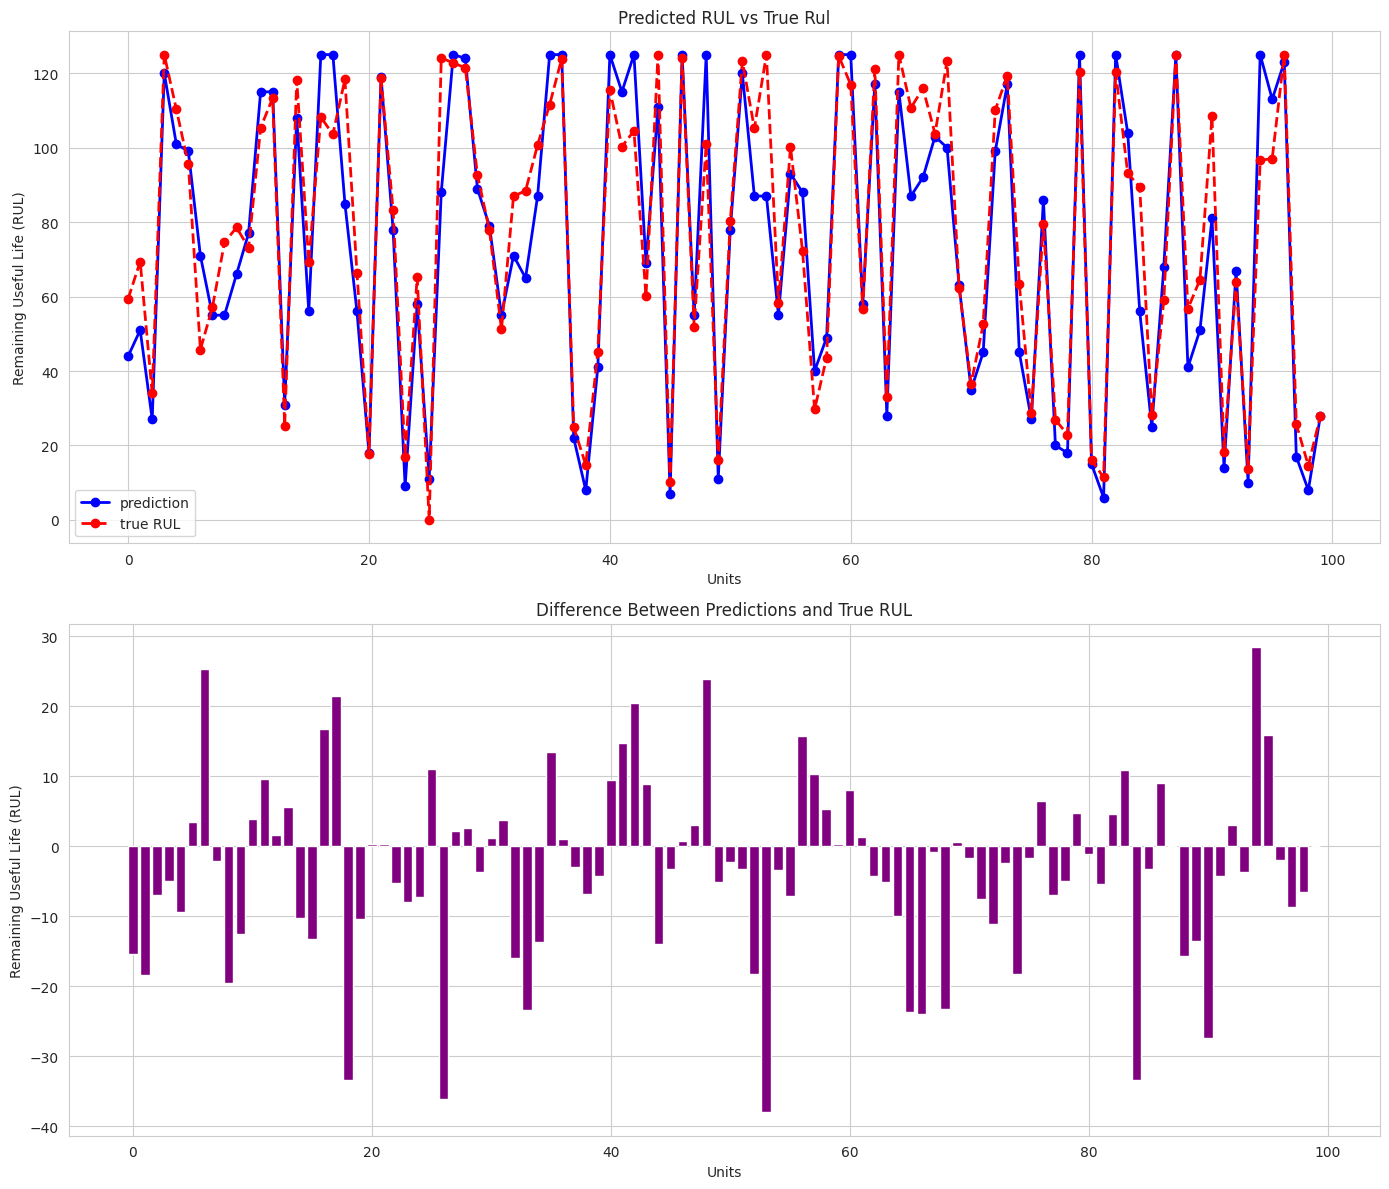

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


# Attention based RUL prediction (for FD004)

In this notebook, we will use attention along with gated recurrent unit (GRU) to make RUL prediction. We will only show the implementation of attention without going too much into the theory and motivation of it. Readers interested to learn more about attention are directed to [Chapter 10](https://d2l.ai/chapter_attention-mechanisms/index.html) of [Dive into Deep Learning](https://d2l.ai/index.html) book. We will use the `Tensorflow` implementation of `Attention Mechanisms` chapter of that book that was in fact written by yours truly (some shameless self-promotion).

This notebook is going to be relatively long. So we have divided it into different sections. Readers can read sections selectively depending on their choice.

* A whirlwind tour of attention
* Data preparation
* Model creation
    * Encoder
    * Attention mechanism
    * Decoder (with attention)
* Model training
* Making predictions
* Evaluating RMSE and S-score
* How to reporduce our result?

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 4


## A whirlwind tour of attention:

![Attention based prediction](attention_mechanism.png)

Attention mechanism was developed to overcome some of the limitations of `encoder-decoder` architecture. Attention mechanism also uses encoder-decoder architecture but with a slight variation. In the vanilla encoder-decoder model, encoder transforms the inputs to a hidden representation. The hidden representation is then passed to decoder model for prediction. One of the limitations of vanilla encoder-decoder model is that for long sequences, the encoded representation is not sufficient to encode all the information of the input sequence. So decoder outcomes become suboptimal. To overcome this challenge, in attention layer, the encoded representation is combined with hidden states of intermediate units to come up with a new hidden representation. As the new hidden representation takes intermediate hidden states into account, it represents the input more effectively. The new hidden representation is then passed to the decoder for prediction. There are basically two steps to attention:

* Attention weight calculation, and
* Linear combination of intermediate states with attention weights

The way in which attention weights (scalars) are computed decides the name of the attention layer. There are infact many ways in which we can compute attention weights. But two of the most commons ones are `Additive attention` and `Dot-product attention` (also called multiplicative attention). Addtive attention computes attention weights in one way while dot-product attention computes it in a different way. After computation of attention weights, new hidden representation is computed and passed to the decoder layer. For more details readers are encouraged to read `Chapter 10` of `Dive into Deep Learning` book.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preparation

Before using our model, we will first process the data. For data preprocessing we will be using three functions as defined below. Without any prior description these functions may seem weird. But these functions are not that difficult to use. A detailed description of the dataset used and preprocessing steps (along with the functions defined below) is given in [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). Readers are strongly encouraged to go through that notebook first to get an intuitive understanding of how the preprocessing steps work.

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    dec_input_data = np.repeat(np.nan, repeats = num_batches * num_features).reshape(num_batches, 1, num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            dec_input_data[batch, :, :] = output_data[batch, :, :][-1]
        return output_data, dec_input_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

We will modify the next functions a little bit to handle a special case. Later, for this dataset, we will be using window_size of 30. But upon some investigation, it can be found that there are a few test engines for which test data doesn't contain 30 rows. If test data for an engine doesn't contain 30 rows, how can we extract 30 rows from it? To circumvent this issue, we will append zeros to the end of that dataset. But while making predictions, we will ignore those appended zeros. This is called masking. The appended extra zeros are masked so that it doesn't influence our prediction. In `Tensorflow`, RNN layers can take a mask argument to ignore specific input values. So we modify the function below to create a mask that is compatible with `Tensorflow`.

Similarly, to the decoder we pass only the last line of every window of test dataset. But if we have appended last few lines of data of an engine by zeros, taking its last row would mean taking all zeros. To overcome this problem, the function returns `test_decoder_for_an_engine` as another output.

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        test_decoder_for_an_engine = test_data_for_an_engine[-1][np.newaxis, np.newaxis, :]
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :], test_decoder_for_an_engine

    else:
        max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1

        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine, test_decoder_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask, test_decoder_for_an_engine

        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine, test_decoder_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask,  test_decoder_for_an_engine

In [ ]:


window_length = 30
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

# train_mask = []
test_mask = []
test_decoder_input = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
# scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine, test_decoder_input_for_an_engine = process_test_data(temp_test_data,
                                                                                                                        window_length = window_length,
                                                                                                                        shift = shift,
                                                                                                                        num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)
    test_decoder_input.append(test_decoder_input_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)
test_decoder_input = np.concatenate(test_decoder_input)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("Test decode input shape: ", test_decoder_input.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-7-196032e79c20>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-7-196032e79c20>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

Processed trianing data shape:  (54028, 30, 21)
Processed training ruls shape:  (54028,)
Processed test data shape:  (1196, 30, 21)
Test mask shape:  (1196, 30)
Test decode input shape:  (1196, 1, 21)
True RUL shape:  (248,)


Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask, test_decoder_input)).batch(128).prefetch(tf.data.AUTOTUNE)

## Model creation

We will first create an encoder, then the attention mechanism (to compute attention weights), then the decoder, and finally combine the encoder and decoder into a single model.

### Encoder

In [ ]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, *args, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

### Additive attention
Along with computing attention weights, we will also compute the linear combination in this layer.

In [ ]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)

    def call(self, state, encoder_outputs):
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1)
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

### Decoder

In [ ]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)

    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)


    def call(self, dec_input, state, **kwargs):
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, initial_state = enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

### Combine encoder and decoder

In [ ]:
class EncoderDecoder(tf.keras.Model):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)

In [ ]:
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

## Combined model

In [ ]:
net = EncoderDecoder(encoder, decoder)

## Training

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    for epoch in range(num_epochs):
        for X, Y in data_iter:
            dec_input = X[:, -1, tf.newaxis]  # Only the last step of each input
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, training = True)
                l = loss_object(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        print(f'epoch {epoch + 1}, {l}')

In [ ]:
train_seq2seq(net, train_dataset, 0.001, 10)

epoch 1, 0.014313381165266037
epoch 2, 0.006666751578450203
epoch 3, 0.007898890413343906
epoch 4, 0.007791964337229729
epoch 5, 0.0066033354960381985
epoch 6, 0.006313679274171591
epoch 7, 0.005051162093877792
epoch 8, 0.004786821082234383
epoch 9, 0.0039688884280622005
epoch 10, 0.0034613392781466246


## Prediction

In [ ]:
def predict_seq2seq(net, test_data_iter):
    final_preds = []
    for test_data_batch, test_mask_batch, test_dec_input in test_data_iter:
        enc_outputs = net.encoder(test_data_batch, mask = test_mask_batch, training = False)
        dec_state = net.decoder.init_state(enc_outputs)
        Y_pred, _ = net.decoder(test_dec_input, dec_state, training = False)
        final_preds.append(Y_pred.numpy())
    return tf.squeeze(tf.concat(final_preds, axis = 0).numpy()).numpy()

In [ ]:
rul_pred_unscaled = predict_seq2seq(net, test_dataset)

In [ ]:
rul_pred = target_scaler.inverse_transform(rul_pred_unscaled.reshape(-1, 1)).reshape(-1)

In [ ]:
true_rul= np.clip(true_rul, a_min=0, a_max=125)
rul_pred = np.clip(rul_pred, a_min=0, a_max=125)

### Computing RMSE and MAE using last 5 examples

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  19.307208861152894
MAE:  12.947639908737715
MAE    0.28641485926044774
S-score:  4137.096708803615


### Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  20.143774727400768
MAE (Taking only last example):  13.546113481685039
MAE    0.2862501236799946
S-score:  5855.827248528431


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 7.169356526806951


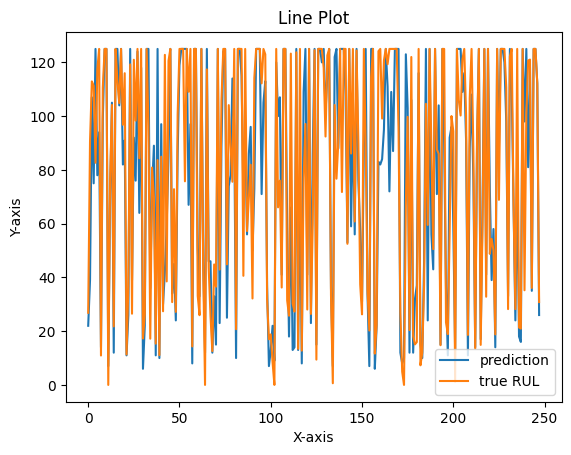

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

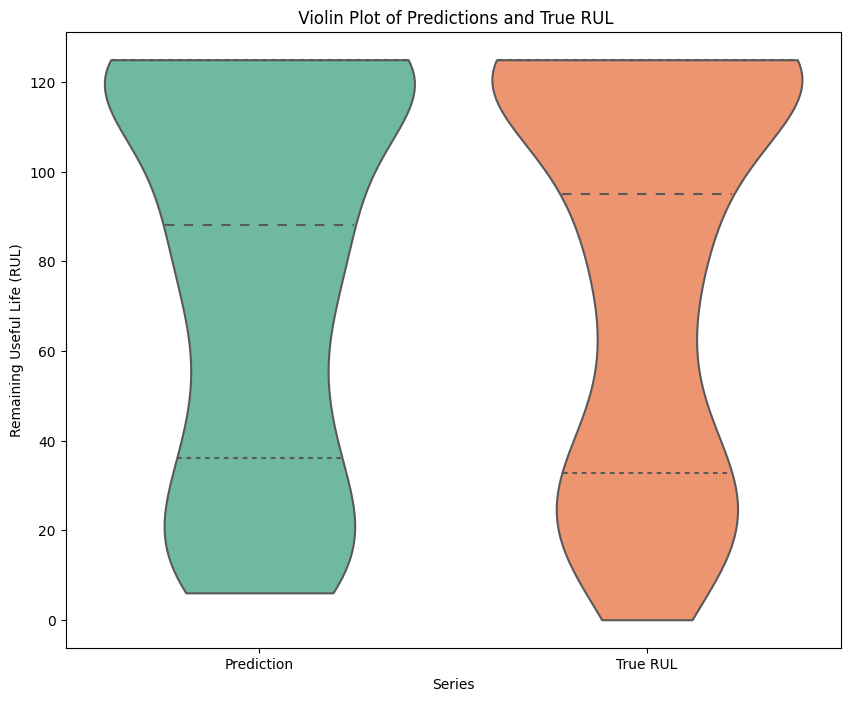

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


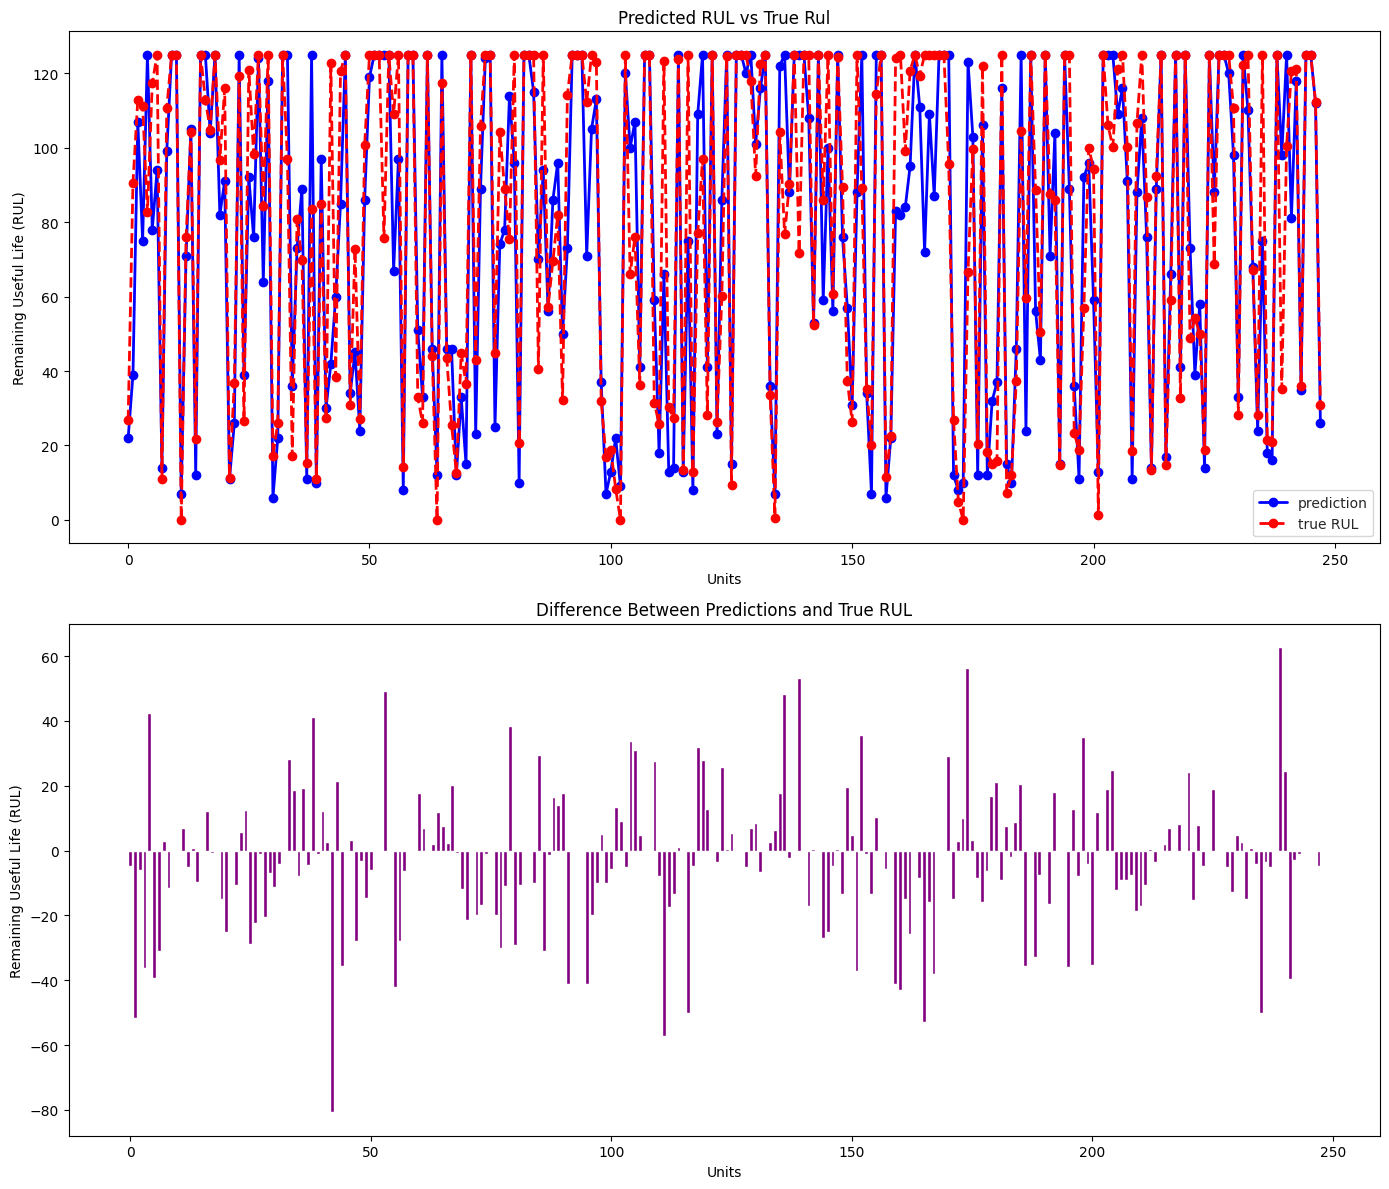

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


#FD001 LAST

| Metric | Value |
|--------|-------|
| RMSE   | 17.75 |
| MAE    | 14.04 |
| MAE    | 0.23  |
| S-score| 615.69|


# fd001 last 5



In [ ]:
| Metric                     | Value |
|----------------------------|-------|
| RMSE (Taking only last examples) | 17.23 |
| MAE (Taking only last example)  | 13.17 |
| MAE                          | 0.22  |
| S-score                     | 571.09|


#fd002

| Metric | Value |
|--------|-------|
| RMSE   | 29.12 |
| MAE    | 20.36 |
| MAE (Normalized) | 0.31  |
| S-score | 26106.96 |


| Metric              | Value |
|---------------------|-------|
| RMSE (Last Examples)| 29.70 |
| MAE (Last Example)  | 21.54 |
| MAE (Normalized)    | 0.35  |
| S-score             | 20578.75 |


#fd003

| Metric              | Value |
|---------------------|-------|
| RMSE                | 13.97 |
| MAE                 | 10.53 |
| MAE (Normalized)    | 0.18  |
| S-score             | 386.69 |


| Metric              | Value |
|---------------------|-------|
| RMSE                | 13.57 |
| MAE                 | 10.47 |
| MAE (Normalized)    | 0.19  |
| S-score             | 369.21 |


Critica


|      Metric      | Value |
|------------------|-------|
| MAE (Critical 1) | 3.38  |
| MAE (Critical 2) | 6.92  |
| MAE (Critical 3) | 5.97  |
